<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2019/blob/master/1b_build_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 1b: Build your Own Tensorflow

© Deep Learning Indaba. Apache License 2.0.

## Introduction

In this practical, we will build a small Python framework that allows us to train our own neural networks, like Tensorflow does. Our framework will depend only on `numpy`. By working through this practical you'll get a chance to understand in more detail how modern deep learning frameworks work, and the basic idea behind Automatic Differentiation, which is a powerful software technique that allows us to quickly and easily compute gradients for all kinds of numerical programs.

$$ 
\newcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\vechat}[1]{\hat{\mathbf{#1}}}
\newcommand{\x}{\vec{x}}
\newcommand{\utheta}{θ}
\newcommand{\th}{\vec{\utheta}}
\newcommand{\y}{\vec{y}}
\newcommand{\b}{\vec{b}}
\newcommand{\W}{\textrm{W}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\xhat}{\vechat{x}}
\newcommand{\yhat}{\vechat{y}}
\newcommand{\bhat}{\vechat{b}}
\newcommand{\What}{\hat{\W}}
\newcommand{\partialfrac}[2]{\frac{\partial{#1}}{\partial{#2}}}
\newcommand{\ipartialfrac}[2]{{\partial{#1}}/{\partial{#2}}}
\newcommand{\dydx}{\partialfrac{\y}{\x}}
\newcommand{\dld}[1]{\partialfrac{\L}{#1}}
\newcommand{\dldx}{\dld{\x}}
\newcommand{\dldy}{\dld{\y}}
\newcommand{\dldw}{\dld{W}}
\newcommand{\idld}[1]{\ipartialfrac{\L}{#1}}
\newcommand{\idldx}{\idld{\x}}
\newcommand{\idldy}{\idld{\y}}
\newcommand{\idydx}{\ipartialfrac{\y}{\x}}
\newcommand{\red}[1]{\color{red}{#1}}
\newcommand{\green}[1]{\color{green}{#1}}
\newcommand{\blue}[1]{\color{blue}{#1}}
\newcommand{\because}[1]{&& \triangleright \textrm{#1}}
\newcommand{\relu}[1]{\textrm{relu}({#1})}
\newcommand{\step}[1]{\textrm{step}({#1})}
\newcommand{\gap}{\hspace{0.5mm}}
\newcommand{\gapp}{\hspace{1mm}}
\newcommand{\ngap}{\hspace{-0.5mm}}
\newcommand{\ngapp}{\hspace{-1mm}}
$$

## Learning Objectives

* Understand the the term **automatic differentiation**.
* Understand **forward** and **backward passes** and their application.
* Understand the **vector-Jacobian products** involved in backpropagation.
* Implement all the steps involved in training a simple **multi-layer perceptron (MLP)** to solve the MNIST digit prediction task.
* Optionally, understand how to mathematically **derive the gradient calculations** for the backward pass.

## Background

This practical will show how to create your *own* deep learning framework from scratch, using only `numpy`. This sounds like a difficult task, but the core ideas are actually suprisingly simple. Understanding how they work will advance your mathematical intuition and put you in a better position to follow (or create) the deep learning innovations of tomorrow! 

Practically all the popular deep learning frameworks (Tensorflow, PyTorch, etc) are based on an algorithm called reverse-mode automatic differentiation (**RAD**). To understand RAD, let's start with a computer program that computes the output of numerical function $y= f(x;\theta)$ when given the input $x$ and parameters $\theta$. RAD gives us a recipe to efficiently compute the **gradient** of the output $y$ with respect to its parameters $\theta$ for this input $x$. Don't worry if you aren't familiar with what a gradient is.

> *Note:* The numerical functions that we will be optimising are usually referred to "neural networks", but there isn't really a fundamental distinction between these two concepts. 

More precisely, these gradients tell us how we should make **small** changes to the network's parameters $\theta$ in order to optimize the final output of the network on some input data $x$. Essentially, if we use the output of our network to calculate a *loss* (which we'll write as $\mathcal{L}$) that measures how badly our network performs on a task, then changing the parameters $\theta$ of the network to reduce $\mathcal{L}$ is the same as making the network perform the task better! This is known as **training** a model. If we base these parameter updates on the gradient of the loss wrt the model parameters, and take small steps along the gradient based on randomly selected sets of examples, then we are performing **stochastic gradient descent (SGD)**, which is the primary method used to train neural networks.

Throughout this practical, you should try to keep these equivalances in mind:


<center>stochastic 
  gradient descent of $\L$<br>$\Updownarrow$<br>
  changing parameters $\theta$ to reduce $\L$ on batches of examples
 <br>$\Updownarrow$<br>
  training our net to perform a task by showing it examples</center>

So just what is reverse-mode automatic differentiation (RAD)? The core idea is fairly simple: it is a recipe for computing gradients of a large, complex function composed of simpler functions by computing gradients for the simpler functions that it is composed of. 

> *Note*: the reason we use the term "reverse-mode" is that the order in which we compute the gradients is reversed from the order we compute the output, but this will become more obvious later. 

> *Note*: We think of these smaller functions as taking vectors (often written as $\mathbf x$) as inputs and producing vectors (often written $\mathbf y$) as outputs. Sometimes $\mathbf x$ and $\mathbf y$ are arrays with more dimensions, like images, but we'll ignore this for now (if you're curious, we effectively treat them as vectors for the purposes of automatic differentiation).

### What are gradient vectors?

> *Note: feel free to skip this if you already understand what a gradient vector represents.*

Let's start with a scalar function $f$, which maps the input $x$ to the output $y$: $$y = \green{f(x)}$$

Here, $f$ could be a polynomial, exponential, or whatever your favorite kind of mathematical function is. 

Let's now  _approximate_ the function $\green f$ around a particular point $x_0$ with a straight-line function $\blue {d\ngap f}$:

$$\blue{d\ngap f(x)} = f(x_0) + \red{f'(x_0)}(x - x_0)$$

<center>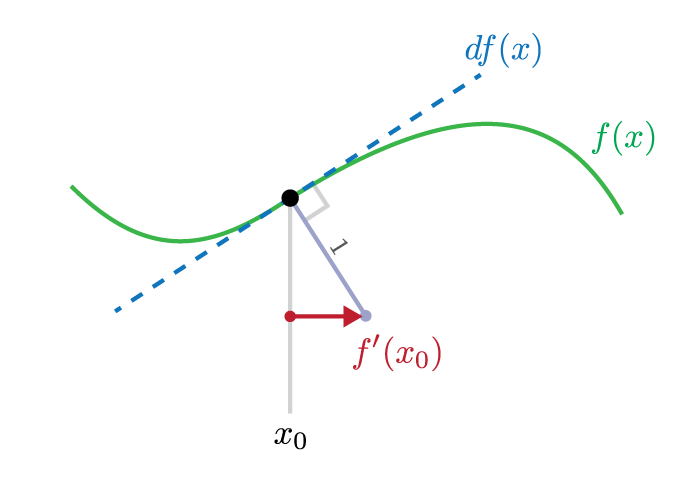</center>

As the picture above shows, we can use the derivative $f' = \frac{dy}{dx}$ to construct the best linear approximation to a function $f$ around a specific point $x_0$. Specifically, the derivative gives us the _slope_. If the function above was horizontal at $x_0$, you can see that the gradient $\red{f'(x_0)}$ would be zero.

Notice the _crucial_ fact that the gradient $\red{f'(x_0)}$ points in the _direction_ in which $\green{f(x)}$ _increases_ at $x_0$, and the magnitude tells us _how quickly_ it increases. Here, the gradient is positive, which tells us the function is increasing to the *right*, and the large magnitdue tells us it is increasing relatively fast.

**Exercise**: does the gradient *always* point in the direction of the nearest maximum of a function? If not, can you provide an example of a point $x$ on a simple function for which the gradient $f'(x)$ does not point toward the nearest maximum of $f$?

### Moving to higher dimensions


We saw how to interpret the gradient of the output of a scalar function with respect to its input. In fact, a similar thing happens if we are working with a function whose input is a *vector* rather than a scalar. However, we must replace the multiplication between the *scalar* derivative $\red{ f'(x_0) }$ and the *scalar* difference $(x - x_0)$, with a dot product between the *vector* gradient $\red{\nabla f(\vec x_0)}$ and the _vector_ difference $(\vec x - \vec x_0)$:

$$\blue{d\hspace{-0.3ex}f(\x)} = f(\mathbf x_0) + \red{\nabla f(\mathbf x_0)}\gap\cdot \gap (\mathbf x - \mathbf x_0)$$

<center>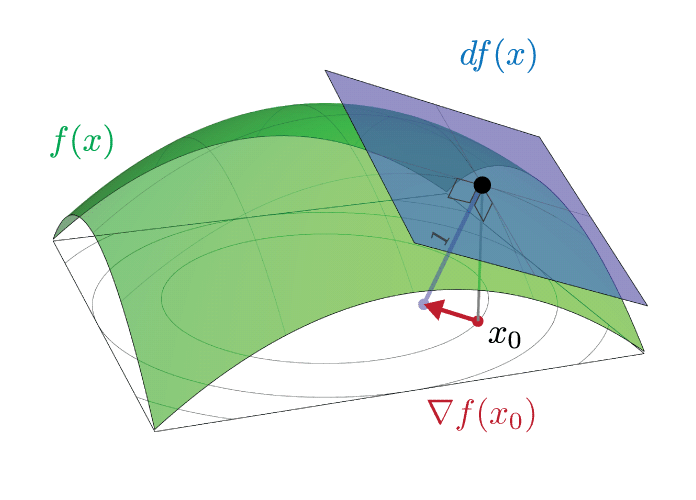</center>


As the picture above shows, this vector gradient represents the slope of the *plane* $\blue{d\ngap f}$ that approximates the surface of $f$ near the point $x_0$. The gradient points in the direction of steepest ascent ("the uphill direction"), and its magnitude tells us the steepness of the plane (so zero gradient means the plane is flat, and a large magnitude gradient indicates a function that is increasing quickly at that point).

> *Note*: You should remember the important fact that the gradient of a function $f(\x)$ with respect to $\x$ is a vector that lives in the same space as $\x$. When we use these gradients to train neural networks, we will take the gradient of a function $f(\x; \th)$ with respect to $\th$, and hence these gradients are in the same space as $\th$. 

> *Note*: the gradient points in the direction of *increase* of the function. For SGD, we will instead be travelling in the direction of *decrease* of the loss $\L$. This means that our updates will simply be based on the negative of the gradient $-\idld{\th}$. 

### Gradient Descent on the Loss Landscape

What do we do in practice with gradients? The illustrations above talked about $f(\x)$, but for training networks we are actually looking at functions $f(\x;\th)$, and considering the gradients with respect to $\th$. 

We will use these gradients to make changes to the $\th$. We measure the gradient $\idld{\th}$ on a *batch* or group of examples, and then change the parameters $\th$ by a small amount in the negative direction of the gradient. Repeating this process again and again, the average loss $\L$ of our network on the examples will hopefully decrease. Eventually, the parameters converge to a local minima of the loss and the network is fully trained (in practice we usually stop before this happens, and various things can prevent it from happening even if we do train forever).

The diagram below shows an idealized picture of the situation: the two dimensional space of the image represents the space of possible settings for the parameters $\th$, so that each point represents a particular network. The green contours show the loss $\L$ as a function of $\th$, pale green showing high levels of loss, darker green showing lower levels. The red arrows show the (negative) gradient vector as measured for each network (blue dot). By updating each network using the gradient we obtain a new, lower-loss network.


<center>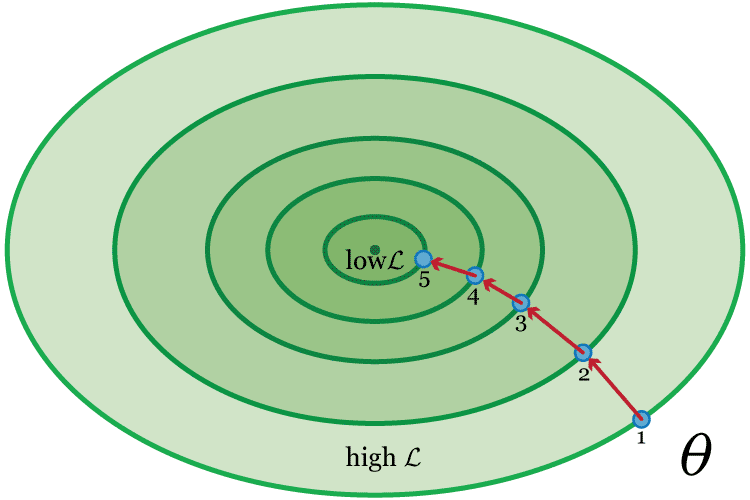</center>


This is often referred to as a "loss landscape". This term makes an analogy with a physical landscape, where "hills" represent high loss and "valleys" represent low loss. Gradient descent is like a traveller always walking downhill, until they are at the lowest point in their local area of the landscape.

**Optional section**: The loss landscape for real neural networks on real tasks is usually very high dimensional, as the the number of parameters is large (typically in the millions). However, it is actually possible to make simplified plots of this loss landscape, by considering a *subspace* of the full space of parameters. Here is a plot of the loss landscape for ResNet-56 on the CIFAR-10 task in the vicinity of a trained network, where the $x$ and $y$ axes are (random) directions in $\theta$ space and $z$ is the loss on the task. The left image is for a resnet without skip connections, the right one is the normal resnet (taken from [Li et al](https://arxiv.org/pdf/1712.09913.pdf)):

<center>
<image src="https://i.imgur.com/8HrLf4j.png" alt="image of loss landscapes of ResNet-56"/>
</center>

### Vector-Jacobian Products and the Chain Rule

We've seen how gradients are useful. This next section will describe how to calculate them in practice. 

We start with the fact that the neural networks are composed of smaller components, often called *layers*, which can be thought of as functions. Now let's imagine that the whole neural network is made of the composition of the functions, e.g. $f = f_1 \circ f_2 \circ f_3$ that are applied in sequence to an input $x$, e.g. $y = f_3(f_2(f_1(x)))$. 

> *Note*: RAD works with more complicated networks than simple chains of functions, but we'll stick with the simple case for explaining the ideas.

Let's visualize this situation in a diagram:

<center>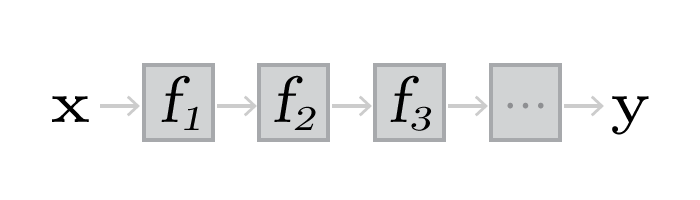</center>


What we're going to do now is consider *one part* of this chain of functions, shown below in the rectangle. We'll talk about this isolated function as $f_i$, and we'll write its input as $\x$ and output as $\y$ (remember this $\x$ and $\y$ are not the same as the input and output of the entire function $f$ that $f_i$ is part of). We also assume that the entire function (which $f_i$ is a part of) will produce a scalar output $\L$ that represents the *loss* of the net on a particular example.

<center>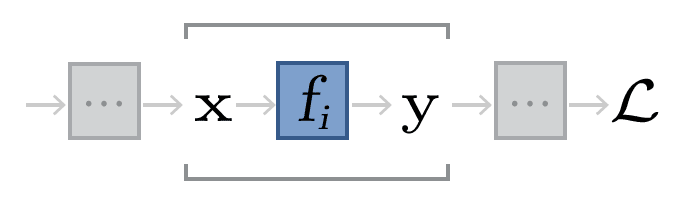</center>


The RAD recipe gives us simple rules that tell us how to deal with each individual $f_i$; these rules then combine naturally to give us the gradient for the entire function. The gradient is "back-propagated" through all the $f_i$, starting at the last $f_i$ and moving backwards towards $f_1$, by calculating what are called vector-Jacobian products. The following diagram depicts one step in this process, corresponding to back-propogation through our selected $f_i$:

<center>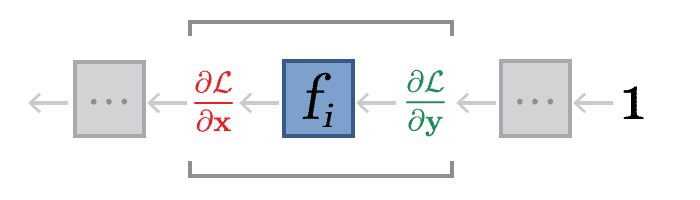</center>


What back-propogation actually does is to compute the gradient of the loss with respect to the input vector $\red{\ipartialfrac{\L}{\x}}$ in terms of the $\green{\textrm{vector}}\textrm{-}\blue{\textrm{Jacobian}}$ product, which is a vector form of the familiar **chain rule** from calculus:

$$\red{\dldx} = \blue \dydx^\mathrm{T}\ngapp   \cdot {\green \dldy}$$

Let's look at all the elements of this equation. We must think carefully about the terms in this equation, as they are *not scalars*, they are arrays. This table summarizes the situation:

|  | Shape | Array Components  | Meaning |
| :--- | :--- | :--- | :--- |
| $\red{\idldx}$ | column vector of size $m,1$ | $\idld{x_i}$ (where $i \le m$) | summarizes how changing input $\x$ will change $\L$
| $\green{\idldy}$ |  column vector of size $n,1$ | $\idld{y_i}$ (where $i \le n$) | summarizes how changing output $\y$ will change $\L$
| $\blue{\idydx}^\mathrm{T} $ | matrix of size $m,n$ | $\ipartialfrac{y_j}{x_i}$ (where $i \le m$, $j \le n$) | summarizes how changing input $\x$ will change output $\y$


Let's write out the individual components of this equation, to make the situation more explicit:

$$\red{\begin{pmatrix}
\ipartialfrac{\L}{x_1}\\
\ipartialfrac{\L}{x_2}\\
\vdots \\
\ipartialfrac{\L}{x_m} \\
\end{pmatrix}}
= 
\blue{\begin{pmatrix}
\ipartialfrac{y_1}{x_1} & \ipartialfrac{y_2}{x_1} & \dots & \ipartialfrac{y_n}{x_1}\\
\ipartialfrac{y_1}{x_2} & \ipartialfrac{y_2}{x_2} & \dots & \ipartialfrac{y_n}{x_2}\\
\vdots & \vdots & \ddots & \vdots \\
\ipartialfrac{y_1}{x_m} & \ipartialfrac{y_2}{x_m} & \dots & \ipartialfrac{y_n}{x_m}\\
\end{pmatrix}}
\cdot
\green{\begin{pmatrix}
\ipartialfrac{\L}{y_1}\\
\ipartialfrac{\L}{y_2}\\
\vdots \\
\ipartialfrac{\L}{y_n}\\
\end{pmatrix}}
$$

The matrix $\blue{\ipartialfrac{\y}{\x}}$ is called a *Jacobian matrix*. It summarizes all the ways in which changing the vector $\x$ by a small amount will influence the vector $\y$. It allows us to transform the gradient vector $\green{\ipartialfrac{\L}{\y}}$ (which summarizes how changing $\y$ will change $\L$), into $\red{\ipartialfrac{\L}{\x}}$ (which summarizes how changing $\x$ will change $\L$). 

The way this transformation works is intuitive: since $\x$ influences $\L$ _through_ $\y$, we can combine all the ways that this influence happens using a matrix multiplication, which linearly sums all the influences through independent components of $\y$. This summing of influences is clear when we write out the matrix multiplication above in component form:

$$\red{\dld {x_i} } = \sum_{j\le n} \green{\dld{y_j}} \blue{\partialfrac{y_j}{x_i}}$$

This equation says: the $\red{\textrm{influence of $x_i$ on $\L$}}$ is the combination\* of all the ways that $\blue{\textrm{$x_i$ influences $y_j$ }} \green{\textrm{which goes on to influence $\L$}}$. This is very intuitive: $\x$ influences $\L$ *through* its influence on $\y$.

> <small>\* Remember that we are assuming these influences are *infinitesimal*, in other words, so small that we can model them one at a time and combine them linearly. Since neural nets usually contain non-linearities, this assumption is *not* true in practice, but if the parameter updates are small enough it is a sufficiently good approximation that we can still use these gradients to optimize the loss $\L$ of a network.</small>

A very important point, though, is that we never actually *compute* the Jacobian matrix $\blue{\ipartialfrac{\y}{\x}}$ directly, or store it as a matrix. Instead, we compute the Jacobian-vector product $\blue{\ipartialfrac{\y}{\x}} \cdot \green{\ipartialfrac{\L}{y}}$ *implicitly*, giving us the vector $\red{\ipartialfrac{\L}{\x}}$. The exact calculation depends on the function/layer, as we will see later, but it is much more efficient than calculating and using the full Jacobian matrix *explicitly*.

All of the above may seem abstract, but try to get comfortable with the basic idea, which is that we are using our knowledge of how the _output_ of a layer influences the final loss $\L$, to compute how the _input_ of a layer influences the final loss! This measurement of influence is summarized by a gradient vector such as $\idldx$. This propogation of gradients from the output of a function to its input is called _backpropogation_, and is the what RAD tells us how to do. 

### A special notation for partial derivatives of the loss 

In this practical we'll be working a lot with partial derivatives of the scalar loss $\L$ with respect to arrays (vectors, matrices, etc.). Normally this would be written as ${\partial \L}/{\partial \mathbf x}$, ${\partial \L}/{\partial \mathbf W}$, and so on. But these quantities are so important and frequent that we're going to introduce a "shortcut" notation for this that is faster to read:

$$\red \xhat := \red{\dld \x}$$

This notation will make it easier to perceive the elegant ideas that are behind automatic differentiation, but it isn't a standardized notation (for example, some other texts use $\tilde x$).


## Implementing the Linear layer

Now that we've seen how we can compute a gradient for a single function using a vector-Jacobian product, we can begin implementing our deep learning framework! We will start with implementing the workhorse layer of all all deep neural nets, which is called (by different people) either the "fully-connected", "linear", "affine", or "dense" layer. 


This layer just computes the function $\y = \W \x + \b$, where $\y$ and $\b$ are vectors and $W$ is a matrix. The input vector $\x$ either comes from the previous layer, or this is the first layer, from the input to the entire network. The $\W$ and $\b$ are the parameters (summarised before as $\th$) which will be learned by gradient descent. The matrix $\W$ is often called the "weight matrix", and the vector $\b$ is called the "bias vector". The general formula for computing the components of the matrix equation $\y = \W \x + \b$ is: 

$$ y_i = b_i + \sum_j W_{ij} \gapp x_j$$

> *Note*: If it isn't clear, the index $i$ and $j$ refer to particular components of the input and output vectors $\x$ and $\y$ respectively. So if, for example, $\x = (x_1, x_2, x_3, x_4)$, then $i$ takes possible values $i = 1, \dots, 4$. We usually don't bother writing these ranges explicitly in summations, etc.

The way you write this in numpy is pretty simple, it is just ```b + W.dot(x)```, so that part is easy!

Let's summarize what we've figured out so far in the form of a Python class. Note that this definition won't be complete, so we're calling it `Linear1` for now... as we add features we'll obtain `Linear2`, `Linear3`, etc.

In [0]:
import numpy as np

class Linear1:
    def __init__(self, num_in, num_out):
        self.W = np.random.randn(num_out, num_in)
        self.b = np.random.randn(num_out)
    
    def forward(self, x):
        y = self.W.dot(x) + self.b
        return y

The `__init__()` method sets up the weight matrix and bias vector with random values, and the `forward()` method computes the output `y` from `x` and the current weights and biases. 

### The forward pass

As you can see, the `Linear` class has one other method, `forward`, which is what computes the output $y$ from the input $x$.

Let's create an instance of this class and apply it to a vector to see that we've got it right. 

**Exercise**: Run the following code, but before you do, try to predict what the output will look like. Hint: try answer if it's possible to know the exact numbers it will contain, given the use of `randn` above?

In [0]:
linear = Linear1(2, 3)
x = np.array([-1, 1])
linear.forward(x)

Below is a diagram that depicts the **computational graph** that we've just implemented, which is the term that is often used for the way that data flows through a network to turn the input $\x$ into the output $\y$ (the parameters $\W$ and $\b$ behave a little like inputs here, as you can see). When we combine many layers together into a multi-layer perceptron (or more complex network), these graphs will "lock together" into a larger graph. 

<center>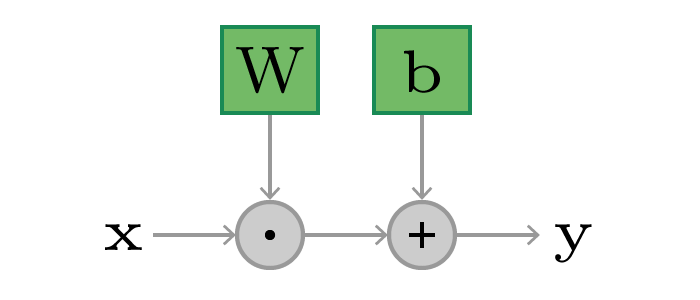</center>

**Exercise**: Make sure you understand how this diagram shows the operation of the `forward(x)` function that we wrote in the definition of the `Linear1` class above. 

### Gradients and the backward pass

Now, we haven't yet tackled the gradients, which involve code to compute the vector-Jacobian product. This is more complex, because there is not just one vector-Jacobian product, there are actually *three*. That is because there are three ingredients of a Linear layer that go into computing $\y$! They are $\W$, $\b$, and $\x$, and each gets its own gradient. Here's a picture that illustrates the computational graph that computes the gradients:

<center>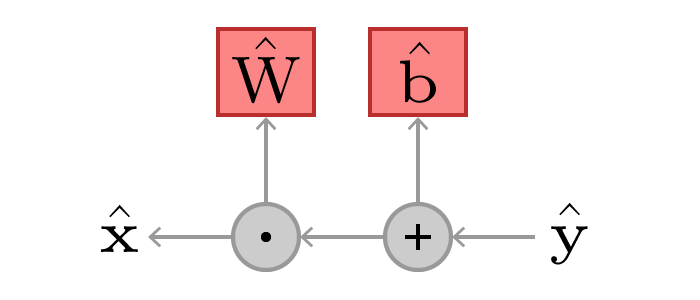</center>

Note that the direction of arrows is reversed. That is because, for example, computing $\hat{\mathbf{x}}$ requires us to know $\hat{\mathbf{y}}$. This is the mirror situation of the forward pass, whereas computing $\mathbf y$ required us to know $\mathbf x$. For this reason, this is called the "backward pass". 

Let's summarize how the backward and forward passes are related:

| Pass | Layer Class Method | Mathematical Notation  | How Chaining Works |
| :--- | :--- | :--- | :--- |
| forward pass | ```.forward(x)``` | $\mathbf y = f(\mathbf x)$ | $\mathbf y$ becomes the $\mathbf x$ for next layer |
| backward pass |``` .backward(yhat)``` | $\hat{\mathbf x} = \hat{f}(\hat{\mathbf y})$ | $\mathbf{\hat x}$ becomes the $\mathbf{\hat y}$ for previous layer |

You can see that there is an interesting symmetry here. The function $\hat f$, which computes the gradients of $f$, is sometimes called the **dual** of $f$.


In practice, the three gradients $\xhat$, $\What$, $\bhat$ that are computed by $\hat f$ are not treated equally. The gradients $\What$ and $\bhat$ will be used to optimize $\W$ and $\b$ using gradient descent, whereas the gradient $\xhat$ will be needed to compute the gradients of the *previous* layer, effectively by becoming the $\yhat$ for _that_ layer. We can summarize this situation in one table, that shows all the things being computed during the forward and backward passes for our `Linear` layer:

| Array  |  Role |  Gradient | Role of Gradient | Shape (of both) |  
| :--- | :---- | :--- | :--- | :--- | 
| $\mathbf x$ | input to $f$ | $\hat{\mathbf{x}}$ |  output from $\hat f$ | vector of size $m$ |
|  $\mathbf W$ | parameter of $f$ |  $\hat{\mathbf{W}}$ | optimize $\mathbf W$  | matrix with $n$ rows, $m$ cols | 
|  $\mathbf b$ | parameter of $f$ |  $\hat{\mathbf{b}}$ | optimize $\mathbf b$ | vector of size $n$ | 
|  $\mathbf y$ | output from $f$ |  $\hat{\mathbf{y}}$  | input to $\hat{f}$ | vector of size $n$ | 

**Exercise**: Look carefully at this table and make sure that you see the symmetry between $f$ and $\hat f$, which reflects the symmetry between the forward and backward passes. Also, note the important fact that every array and its gradient are the same shape -- is it straightforward to see why this *must* be true?

### Implementing the backward pass

The forward pass (the $f$) for `Linear` was very simple, being essentially `W.dot(x) + b`. What does the backwards pass (the $\hat f$) for `Linear` look like? What should it even do? Looking at the table above, we can see it needs to compute the quantities $\What$, $\bhat$, and $\xhat$. However, of these three, only $\xhat$ will be needed by the previous layer. $\What$ and $\bhat$ need to be stored somewhere so that we can use them to optimize the values of $\W$ and $\b$. Therefore, we can implement $\hat f$ as a Python method that returns $\xhat$, but _stores_ $\What$ and  $\bhat$ somewhere.

In fact, the layer itself will contain these arrays $\What$ and $\bhat$, and the `.backward(y_hat)` method will modify them. Let's see how this might work (note: this code uses 0 as a placeholder, since we haven't figured out how to derive the gradient computations yet!):

In [0]:
class Linear2(Linear1): # <- inherit __init__ and forward from Linear1
    
    def backward(self, x, y_hat):
        raise NotImplementedError
        self.W_hat = 0 # TODO: compute and store W_hat
        self.b_hat = 0 # TODO: compute and store B_hat
        return 0       # TODO: compute and return x_hat

Using vector calculus we can compute the mathematical expressions for the vector-Jacobian products that will give us expressions for $\hat x$, $\hat W$, and $\bhat$. To do this is straightforward but requires some time-consuming mathematical derivations, and so we have left the full derivations to an appendix at the end. We encourage you to read these if you are interested, you will learn a lot! 

Here, we will summarize show a simple derivation for the gradient of the bias term ($\bhat$), however, because it has a simple result and an intuitive explanation:


\begin{align}
\hat{b}_i :=& \gapp \dld{b_i} \\
=& \sum_j {\dld{y_j} \partialfrac{y_j}{b_i} } \because{vector-Jacobian product} \\
=& \sum_j {\dld{y_j} \partialfrac{\left(  b_j  + \sum_k W_{jk} \cdot x_k \right)}{b_i}} \because{substitute the definition of $y_j$} \\
=& \sum_j {\dld{y_j} \partialfrac{b_j }{b_i}} \because {other terms are constant w.r.t. $b_i$}\\
=& \gapp \dld{y_i} \because{only the term with $i = j$ is non-zero} \\
:=& \gapp \hat{y}_i 
\end{align}

In other words, the gradient $\bhat$ for the bias vector $\mathbf b$ is simply the gradient $\yhat$ for the output $\y$ of the linear layer. This is intuitive if you think about it: the biases are  simply added in the expression $\y = \W \x + \b$ to the other term to give $\y$, so increasing each component of the bias directly increases the corresponding component of $\y$ by _exactly the same_ amount.

**Exercise**: make sure you are happy with the reasoning given above. If necessary, remind yourself what a gradient represents in terms of "influence".

Here's a summary of the gradients for *all* the parameters of the Linear layer, and the corresponding numpy code that computes them:

| Gradient | Mathematical expression | Numpy computation |  
| :---: | :--- | :--- |
| $\xhat$ | $W^T \yhat$ | `W.T.dot(y_hat)` |
| $\What$ | $\yhat \otimes \x$ | `np.outer(y_hat, x)` |
| $\bhat$ | $\yhat$ | `y_hat` |

We're now ready to implement the `backward` method properly that we started in `Linear2`. Remember that our `backward` method is supposed to *store* the parameter gradients $\What$ and $\bhat$, and _return_ the input gradient $\xhat$.

In [0]:
class Linear3(Linear1): # <- inherit __init__ and forward from Linear1
    
    def backward(self, x, y_hat):
        self.W_hat = np.outer(y_hat, x)
        self.b_hat = y_hat
        return self.W.T.dot(y_hat)

### Connecting the forward and backward pass

Ok, so we have a definition of the `forward` and `backward` method of our `Linear` class. But how do these fit together, exactly? And how do we use them to train a network? 

Before we go any further, one thing should be clear from our definition of `backward`: it needs to know both `y_hat` *and* the the original input `x` to the layer in order to compute the three gradients. But if the `forward` and `backward` passes are going to be run at different times, how will the value of `x` used in the forward pass be available to the backward pass? 

One simple answer is if the `forward` method simply _memorizes_ the value of $x$ so that the `backward` method has access to it. There is a very simple and elegant way of doing this, which is to have the `forward` method return two things: the output $y$, but *also* a **lambda function** that applies the backward pass using the _current_ value of $x$:

> *Note*: You can think of a lambda function as a simple function that doesn't have a name, just a definition


In [0]:
class Linear4(Linear3): # <- inherit backward method from Linear3
    
    def forward(self, x):
        y = self.W.dot(x) + self.b
        dual = lambda y_hat: self.backward(x, y_hat)
        return (y, dual)

This lambda function simply stores the value of `x` inside it, so that it can be passed to `backward` when needed.

> *Note*: in software programming, there is a special name for a temporary function that "owns" or stores data inside it like this: it is called a *closure*. When the temporary function is no longer needed, the stored data goes away as well, which is what we want (this process of automatically forgetting unneeded data is called *garbage collection*).

### The final Linear class: SGD and batching

To make everything clearer, let's define a final version of the `Linear` class that is self contained and puts all of the definitions together. 

We are also going to use this opportunity to implement basic SGD optimization, as well. We do this by defining a `descend()` method that adjusts the parameters to reduce the loss. It takes a `step_size` argument that determines how large a step should be taken. 

Note we are now using `+=` in `backward(..)` to set `W_hat` and `b_hat` so that the gradients can easily be summed across many examples, and we reset these gradients to zero after taking one descent step. *This allows us to gather the gradients for many examples together into a batch, before doing one step of SGD.*

In [0]:
import numpy as np

class Linear:
  
    def __init__(self, num_in, num_out):
        self.W = np.random.randn(num_out, num_in)
        self.W *= 2 / np.sqrt(num_in + num_out) 
        # ^ we use a variant of He initialization
        self.b = np.zeros(num_out)
        self.W_hat = np.zeros_like(self.W)
        self.b_hat = np.zeros_like(self.b)
    
    def forward(self, x):
        y = self.W.dot(x) + self.b
        dual = lambda y_hat: self.backward(x, y_hat)
        return (y, dual)
      
    def backward(self, x, y_hat):
        self.W_hat += np.outer(y_hat, x)
        self.b_hat += y_hat
        return self.W.T.dot(y_hat)
      
    def descend(self, step_size):
        self.W -= step_size * self.W_hat
        self.b -= step_size * self.b_hat
        self.W_hat.fill(0) # reset the gradients to zero
        self.b_hat.fill(0)

**Exercise**: what would happen if we did NOT set $\What$ and $\bhat$ to zero after doing one step of SGD?

We can now use this final definition of the linear layer to compute the output $\y$ *and* the three gradients $\xhat$, $\bhat$ and $\What$. Here is some code that calculates the gradients for a single Linear layer on a particular input, and prints them:


In [0]:
# make a linear layer that maps 2-vectors to 2-vectors
layer = Linear(2, 2)

# feed it the input vector [2, -3]
x = np.array([2, -3])
y, dual = layer.forward(x)

# print the output
print("output = ", y)

# compute the gradients for y_hat = [1, 1]
y_hat = np.array([1, 1])
x_hat = dual(y_hat)

# print all the gradients
print("x_hat =", x_hat)
print("b_hat =", layer.b_hat)
print("W_hat =", layer.W_hat)

Remember the interpretation of these gradients: they represent the influence that $\x$, $\b$ and $\W$ have on the output of the net. In this case, we *imposed* a value for $\yhat$ to "jumpstart" our calculation, but normally this would depend (via backpropagation) on the way that we define the loss $\L$ of the network. We will go into more later on.

## Implementing a non-linearity

Our next to ask is to implement a non-linearity such as **relu** (which is short for rectified linear unit). Relu is applied to each scalar element of a vector individually (called *element-wise*), returning either 0 if the element is negative, or the element itself if it is positive. Therefore the derivative of **relu** is **step**, which is a function that is $0$ for $x < 0$ and $1$ for $x > 1$.

<center>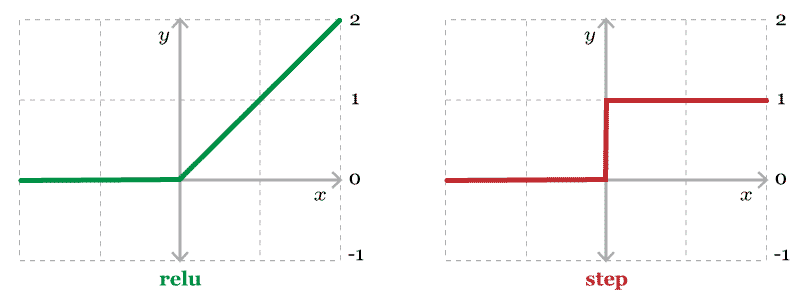</center>




Since Relu has no parameters, we only need to compute the value of $\xhat$ from $\yhat$ (see the appendix for our derivation of this code):

In [0]:
class Relu:
    def forward(self, x):
        positive_mask = x > 0 
        y = x * positive_mask
        dual = lambda y_hat: y_hat * positive_mask
        return (y, dual)
      
    def descend(self, step_size):
        pass # no parameters to optimize

## How functions chain

So far, we've defined just a single layer, and how it computes the parameter gradients $\What$, $\bhat$ as well as the input gradient $\xhat$. 

But a single layer can't do much on its own. How can we "compose" several of these layers together into a deeper net? 

The answer is that we can define a new class (called `Chain`) that represents a **composition of layers**. It will also have a `forward` method that computes the output $\y$ of the whole chain, as well as returning a dual function that computes the gradients when given a $\yhat$.

If you have a list of layers `functions = [f1, f2, ..]`, then it is easy to apply them in sequence using a simple for loop:

```
for f in functions:
    x = f(x)
```

(After this for loop has executed, the variable `x` will hold the output)

We will do a similar thing for the `forward` method of `Chain`, except we will *also* compose the dual functions. Remember, the dual functions are not *run* during the forward pass, they are merely composed (in reverse order):

In [0]:
# return a function that applies f and then g
def compose(g, f):
    return lambda x: g(f(x))

class Chain:
    def __init__(self, *layers):
        # create a chain using Chain(layer1, layer2, ...)
        self.layers = layers

    def forward(self, x):
        dual = lambda y_hat: y_hat # <- empty chain acts like identity
        for layer in self.layers: 
            # apply each layer to previous input
            x, d = layer.forward(x)
            # compose dual function of layer with previous dual functions
            dual = compose(dual, d) 
        # return final output, and composition of all duals
        return x, dual
      
    def descend(self, step_size):
        for layer in self.layers:
            layer.descend(step_size)

Let's try out our new `Chain` layer. We start by making a new chain that contains a linear layer, a non-linearity, and then another linear layer. The input to the whole chain is a vector of size 2, the output is a also a vector of size 2:



In [0]:
chain = Chain(Linear(2, 3), Relu(), Linear(3, 2))

This network corresponds to the following multi-layer perceptron (MLP). Remember that each "layer" like a Linear layer corresponds to a pair of neighboring stacks of "units" or "neurons". The lines represent all the individual components of the weight matrix.

<center>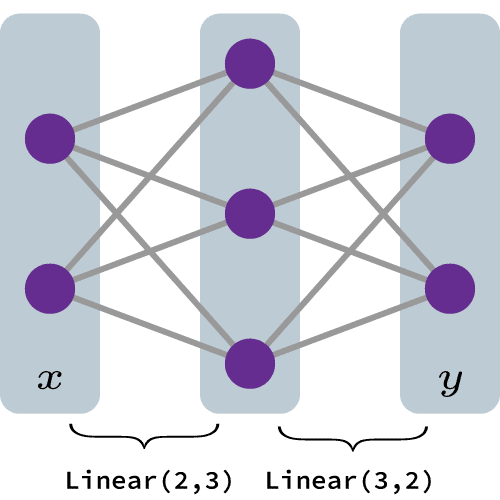</center>


Let's evaluate the Chain on a single example:

In [0]:
x = np.array([1, -1])
y, dual = chain.forward(x)
print(y)

In addition to the output value `y = f(x)`, we also have now the dual function stored in `dual`. Remember, this dual function (which we wrote before as $\hat{f}$) maps a tangent\* vector $\yhat$ at $\y$ to a tangent vector $\xhat$ at $\x$, in other words, it gives us $\xhat = \hat{f}(\yhat)$. 

The tangent vector $\xhat$ tells us that if we were to start at $\x$ and move a small distance $\epsilon$ along $\xhat$, the output $\y$ would move a small distance $\epsilon$ along $\yhat$. In other words, the dual function $\hat{f}$ tells us which direction to move in the input space if we want to move a certain direction in the output space. This is exactly what we need for optimization!

> <small>\*By tangent vector $\xhat$ at $\x$, we mean a vector $\xhat$ that lives in the "tangent space" at $\x$. You can think of the tangent space of a vector being the space of _possible velocities_ of that vector, if you think of that vector being able to change in time. Seen from this perspective, backprop allows us to easily compute the (linear) relationship between the velocities of inputs and the velocities of outputs of a function.</small>

<center>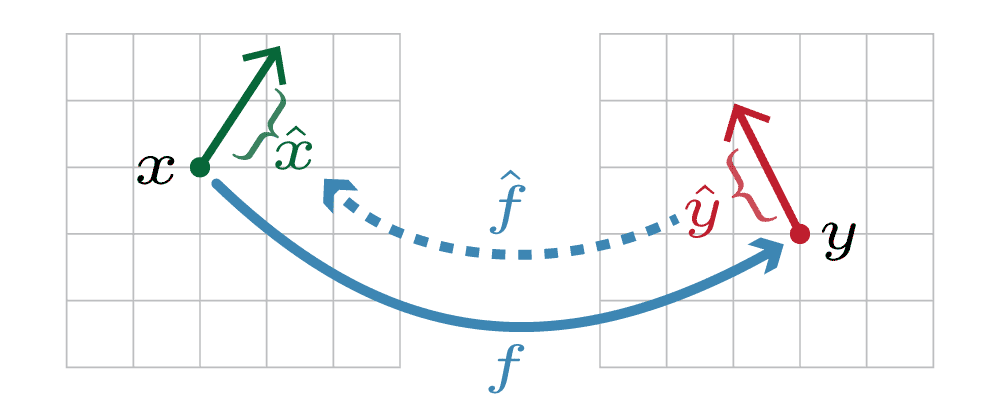</center>


What 'seed' value should we choose for $\yhat$? That's up to us, and depends on how we *want* our network's output to change when we optimize it. That depends on how our scalar loss value $\L$ depends on $\y$. 

In some applications, like most supervised learning, the loss $\L$ can be computed directly within the network, and the final output of this training network is hence $y = \L$. Therefore we should set $\yhat = \idld{\y} = \idld{\L} = 1$.

In other applications, the final loss is computed outside the network, and we set $\yhat$ as appropriate. This happens for example in some policy gradient methods that are used in reinforcement learning.

## Defining a loss function

From the previous discussion, you should understand that before we can train our network, we need to define how the loss $\L$ depends on the output of our net. That will allow us to fix a value for $\yhat$, which is needed to 'seed' the backpropagation operation in order to compute $\idld{\th}$, the gradients of our parameters. 

To keep things simple, we will be implementing the so-called L2 loss, which measures how far the output $y$ is from the true output $y'$, and defines the loss to be:

$$\L = (y - y')^2$$

Here is this function. It takes the model, the input to pass to the model, and the target output. It then computes the actual output, and calculates the gradients of the parameters such as to minimize this loss.

In [0]:
def L2_loss(model, x, y_target):
    # compute the output of the model:
    y, dual = model.forward(x)
    
    # compute the loss
    loss = np.mean((y - y_target) ** 2)
    
    # compute y_hat
    y_hat = 2.0 * (y - y_target) # = d(loss)/dy
    
    # trigger backpropagation
    dual(y_hat)
    
    return loss

Let's try it out! The following code will feed random vectors to our previous multi-layer-perceptron, and compute a loss that measures how similar the output of the network is to the input of the network. In other words, the task here is for the MLP to behave like the identity function:

In [0]:
x = y = np.random.randn(2)
L2_loss(chain, x, y)

We can now use the gradients computed by `l2_loss` to do SGD. Re-evaluating the loss on the original example should show that it has decreased:

In [0]:
chain.descend(0.1)
L2_loss(chain, x, y)

**Exercise**: how would you modify the above code to make the loss *increase*?

## The training loop 

Let's define a `train` function that applies this process repeatedly to train the network on a task. The loss as a function of time will be plotted in a log plot:

In [0]:
import matplotlib.pyplot as plt

def to_array(x):
    return np.array(x, copy=False, ndmin=1)

def train(model, data_generator, total_batches, batch_size=64, learning_rate=0.01, loss_function=L2_loss):
    losses = []
    
    period = np.floor(total_batches / 10) # how often to print loss
    avg_loss = 0 
    
    print("batch\tloss")
    
    for batch_number in range(1, total_batches + 1):
      
        # collect gradients from `batch_size` examples
        loss = 0 
        for i in range(batch_size):
            x, y = data_generator()
            loss += loss_function(model, to_array(x), to_array(y))
        loss /= batch_size
        losses.append(loss)
    
        # periodically print the loss
        avg_loss += loss    
        if batch_number % period == 0: 
            print(f"{batch_number}\t{avg_loss/period:0.3g}")
            avg_loss = 0
        
        # do a step of SGD, using a gradually decreasing learning rate
        schedule = np.sqrt(1.0 - (batch_number - 1) / total_batches)
        step_size = learning_rate / batch_size * schedule
        model.descend(step_size)

    plt.semilogy(losses)
    plt.show()

This function takes the following arguments:

| argument | meaning |
| ---- | ---- |
| `model` | the model to train |
| `data_generator` | a function that will generate `(x, y)` example pairs | 
| `total_batches` | the number of batches to train on before stopping |
| `batch_size` | the number of examples to combine in each batch |
| `learning_rate` | the size of the gradient descent steps to take |
| `loss_function` | the loss function to use |

Note that we defined *default* values of `batch_size=64`, `learning_rate=0.01`, and `loss_function=L2_loss`, so these arguments are optional.

Let's put the `train` function to work! To do this we first define a generator function that will make a random 2-vector and returns it as both the `x` and `y` values, since we want out network to reproduce the input as its output. Essentially, we will be teaching the network to act like the *identity function*:

In [0]:
def make_random_data():
    x = np.random.randn(2)
    return x, x

Let's define a simple multi-layer perceptron for this task, and begin training it:

In [0]:
mlp_identity = Chain(Linear(2, 3), Relu(), Linear(3, 2))
train(mlp_identity, make_random_data, 2000)

You should see a curve and table that shows the loss going down slowly. It should be in the range 0.05 - 0.3 by the end of training.

Now that we have trained the net, let's try the trained MLP on a particular input and see how close it is to reproducing the input vector of `[1, -1]`:

In [0]:
x = np.array([1, -1])
y, _ = mlp_identity.forward(x)
print(y)

It's not 100% perfect, but it's pretty good! 

**Exercise**: try write a simpler network that just consists of a single linear layer, and train it on this task. What shape must this linear layer have?

## Training on MNIST

We are now going to train on *half* of the famous MNIST (pronounced "em-nist") dataset of handwritten digits (taking only the digits 0 through 4). 

### Getting the training data

To access the data, we will use tensorflow - but we will not use any other functionality from tensorflow.

In [0]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

The variables `x_train` and `x_test` each store a numpy array that contains the 60,000 images and the labels respectively. 

In [0]:
print("x shape is", x_train.shape)
print("y shape is", y_train.shape)

The dimensions 28, 28 are the width and height of the images in the training set.

### Visualizing the training data

Let's visualize some of the training data. Here's a function that plots an array as an grayscale image:


In [0]:
import matplotlib.pyplot as plt

def plot_image(array):
    plt.imshow(array, cmap='gray_r');

The following code will take the first 10 image arrays from the training set, stack them horizontally into one 2-dimensional array, and plot it using our new function. We are also printing the first 10 labels so we can compare them.

In [0]:
plot_image(np.hstack(x_train[1:10]))
print(y_train[1:10])

As you can see, the *i*'th label corresponds to the *i*'th handwritten digit!

### Sampling from the training data

We now write a function that will sample at random an image and its matching label, returning them as a pair. The `while` loop will make sure we get a digit that is either zero, one, two, three, or four - it'll keep trying again until it gets one:

In [0]:
def sample_random_mnist_example():
    # keep sampling until we get a digit in range 0..4
    while True:
        i = np.random.randint(60000)
        x = x_train[i].flatten()
        y = y_train[i].flatten()
        if y[0] < 5: break
    return x, y

Let's try this function out. Notice that the single 1 x 28 x 28 array representing the image into a 784-dimensional vector. Similarly, the label is stored in a 1-dimensional vector.

In [0]:
x, y = sample_random_mnist_example()
print("x shape is", x.shape)
print("y shape is", y.shape)

### Optional reading: can we expect problems from using L2 loss for classification?
 
The training data labels are the integers 0, 1, 2, .., 9, corresponding to a training image of the handwritten digit zero, one, two, etc. 

To re-use our previous code, the loss function we will use for this problem is the L2 loss. However, this choice of loss function has several problems. In fact, it's really bad!

To see why, let's look at two kinds of misclassification the net might do:

1. the net predicts **y = 0** but the actual label is **y' = 4**. This gives a **high** L2 loss value of $\L = (y - y')^2 = (0-4)^2 = 16$
2. the net predicts **y = 0** but the actual label is **y' = 1**. This gives a **low** L2 loss value of $\L = (y - y')^2 = (0-1)^2 = 1$

But this difference not ideal, because we as human beings care equally about both these misclassifications! Using the L2 loss function will train the net to minimize one kind of error much more than the other kind of error.

Similarly, our net will usually predict non-integer values like `3.8` or `5.2`, which we will choose to interpret as predictions for the nearest integer, like four or five. Again, this is unnatural, because it only allows the network to express uncertainty between neighboring numbers three versus four -- it cannot express uncertainty between zero and four!

A much better choice of loss function is called the *cross-entropy loss*, which has none of these problems. We will leave this as an exercise in a later section.


### Training the net 

In [0]:
mnist_mlp = Chain(Linear(28*28, 100), Relu(), Linear(100, 1))
train(mnist_mlp, sample_random_mnist_example, 1000, learning_rate=0.1)  

You should see a steadily decreasing loss curve above, with a final loss of around 0.05 to 0.2 (try again if the loss remains high by the end of training).

Let's try the trained net out on an example from the test set.

In [0]:
x = x_test[1]
plot_image(x)

You should see an image of a handwritten digit two above. So if we are lucky, the net should predict a label that is close to the value `2.0`:

In [0]:
y, _ = mnist_mlp.forward(x.flatten())
y

We can try to evaluate the performance by hand, but this isn't very scientific. So let's measure the accuracy on the entire test set, which contains 10,000 examples. We'll do this by looping over all examples in the test set, testing whether the output of the net, when rounded to the closest integer, gives the true label. We'll then return the fraction of examples that were correctly classified:

In [0]:
def measure_mnist_accuracy(model, to_prediction=np.round):
  
    number_correct = number_seen = 0
    for i in range(10000):
        x = x_test[i]
        y_target = y_test[i]
        
        # skip labels not in 0..4
        if y_target >= 5: 
            continue      
            
        # get net's prediction
        y, _ = model.forward(x.flatten())
        
        # update count of number of correctly predicted examples
        if to_prediction(y) == y_target: 
            number_correct += 1
        number_seen += 1
        
    return number_correct / number_seen

We've written this as a function so that it is easy to use again later. The first argument is the model whose predictions should be measured. We also have an optional `to_prediction` argument to allow us to test nets that have output of different forms than a single real number (we'll need this later when we investigate cross-entropy).

Let's try it out on the model we just trained:

In [0]:
measure_mnist_accuracy(mnist_mlp)

You should see an accuracy in the range 70-90%. If you don't, try running the `train` step again and testing the accuracy one more time -- sometimes the random initialization of the net just doesn't allow it to learn as well.

### Exercise: switching to cross-entropy loss

We should be able to improve our training process by using the so-called **cross-entropy loss** (CE loss) instead of L2 loss. This will avoid the problem of some misclassifications (e.g. 0 vs 4) contributing much more loss than others (0 vs 1).

For simple situations like MNIST, the CE loss can be defined as follows, where $y$ is a vector of probabilities, one for each class, and $i$ is the index of the _true_ class:

$$\mathrm{CE}(y, i) = - log(y_i)$$

**Simple exercise**: convince yourself that minimizing this loss will encourage the likelihood of the _true_ class to be high. 

How do we get our network to produce a vector of probabilities? The most common way is to use the so-called **softmax function**, which is defined as:

$$\textrm{softmax}(\x) = \frac{e^{\x}}{\sum e^\x}$$ 

In English terms: we exponentiate the input vector, and then normalize. This last step ensures the components of the vector will add up to 1, so that the vector can be interpreted as a vector of probabilities (because probabilities over all the classes must sum to 1).

We won't spend much time explaining cross entropy loss and softmax, though there is a lot more to say. Instead, we will cut to the code. This code will combine both the cross entropy and softmax operations into a single expression that is more numerically stable:

In [0]:
def cross_entropy_loss(model, x, y_target):
  
    # compute the output of the model
    y, dual = model.forward(x)
    
    # compute the loss
    index = round(y_target[0]) 
    log_softmax = y - np.log(np.sum(np.exp(y)))
    loss = -log_softmax[index]
    
    # compute y_hat
    y_hat = np.exp(log_softmax) 
    y_hat[index] -= 1
    
    # trigger backpropagation
    dual(y_hat)
    
    return loss

**Exercise**: derive from scratch the code for `loss`, which combines the computation of softmax and the cross entropy into one step. 

**Harder exercise**: derive the code for `y_hat` from first principles. Hint: remember you are trying to compute $\idld{y}$, and you will need to use the chain rule through the combined log-softmax operation. 

Let's try it out:

In [0]:
mnist_mlp_ce = Chain(Linear(28*28, 100), Relu(), Linear(100, 10))
train(mnist_mlp_ce, sample_random_mnist_example, 1000, learning_rate=0.1, loss_function=cross_entropy_loss)  

In [0]:
measure_mnist_accuracy(mnist_mlp_ce, to_prediction=np.argmax)

We should see the accuracy here is much higher than when we used L2 loss! In fact, it should be in the range 95-99%. Here, the theoretical problems with L2 loss corresponded to a large deficit in actual accuracy!

## Conclusion

In this practical we discussed what *gradients* of a differentiable function represent, how reverse-mode automatic differentiation allows us to calculate gradients, and how these correspond to vector-Jacobian products. We used this theoretical foundation to implement a simple deep learning framework that we used to train a multi-layer perceptron to solve the MNIST classification task, with good accuracy.

By following this practical and understanding the underlying ideas you'll be in a much better position to understand how modern deep learning frameworks work, why it is efficient, and what you might need to do to implement your own advanced layers if you need to.

## Extra reading

* [Blogpost: Backpropagation by Chris Olah](http://colah.github.io/posts/2015-08-Backprop)

* [Video: 3b1b episode about backpropogation](https://www.youtube.com/watch?v=tIeHLnjs5U8)

* [Wikipedia page on automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)

### Advanced:

* [Video: Lecture on Automatic Differentiation from the 2018 MLSS in Stellenbosch](https://www.youtube.com/watch?v=23ksBFYWIcM)

* [Video: Some Principles of Differentiable Programming Languages from POPL2018](https://www.youtube.com/watch?v=qhPBfysSYI8)

* [Wikipedia page on dual numbers](https://en.wikipedia.org/wiki/Dual_number)

* [Paper: The simple essence of automatic differentiation](https://arxiv.org/abs/1804.00746) (ironically, this is not a particularly simple paper)

# Appendix

This appendix will explain how to derive the code for the backward pass of the Linear and ReLU layers, using the vector-Jacobian product. It is optional reading, but strongly encouraged to help build your intuition and confidence with the mathematics that underlies automatic differentiation. It will also give you the confidence to try to write your own layers!

## Recap of differentiation

Here is a quick list of some basic rules for rewriting sums, products, and derivatives that you can quickly review to make sure they are familiar. Here, $\newcommand{\defineblock}[2]{\newcommand{#1}{#2{\hspace{0.1ex}\blacksquare \hspace{0.1ex}}}#1} \defineblock{\xa}{\red}$ and $\defineblock{\xb}{\blue}$ stand for *any* expression you like, and remember, multiplication $\times$ is not _normally_ written explicitly, it is implied when two expressions are next to each other, but we will use $\times$ here to be clearer.

1. Differentiating a sum:

$$
\partialfrac{\left(\xa + \ngapp \xb\right)}{x} \gapp = \gapp \partialfrac{\xa}{x} + \partialfrac{\xb}{x}
$$

2. Differentiating a product:

$$\partialfrac{\left(\xa \times \ngapp \xb\right)}{x} \gapp = \gapp \xa \times \partialfrac{\xb}{x} + \xb \times \partialfrac{\xa}{x}$$

However, it's more common that *some* parts of an expression **do not** depend on $x$. Then you can apply simpler rules (which are special cases of the rules above). Again, $\defineblock{\xc}{\color{gray} }$ and $\defineblock{\xd}{\color{orange}}$ stand for *any* expression you like.

3. Differentiating a sum when $\xc$ **does not** depend on the variable $x$:

$$\partialfrac{\left(\xc + \ngapp \xd\right)}{x} \gapp = \gapp \partialfrac{\xd}{x}$$

4. Differentiating a product when $\xc$ **does not** depend on the variable $x$:

$$\partialfrac{\left(\xc \times \ngapp \xd\right)}{x} \gapp = \gapp \xc \times \partialfrac{\xd}{x}$$

5. Differentiating an expression $\xc$ that **does not** depend on $x$ at all:

$$\partialfrac{\xc}{x} = 0$$

Lastly, there are two rules for sums $\Sigma$ that are very useful:

6. Factoring sum of products when $\xc$ **does not** involve the summation index $i$:

$$\sum_i \xc \times \ngapp \xd \gapp =\gapp \xc \times \sum_i \xd$$

7. Sum of products with a Kronecker delta:

$$\sum_i \delta_{ij} \times \xd \gapp = \underbrace{\hspace{1ex} \xd \hspace{1ex}  }_{\textrm{$i$ replaced with $j$}}$$

This last rule, and the meaning of the symbol $\delta$, will be explained in the next section.

#### The Kronecker delta symbol $\delta_{ij}$



In the derivations that follow, we will be deriving expressions for the various vector-Jacobian products. A very common situation is that we will need to take the partial derivative of an indexed expression, like $b_i$ (which represents the $i$'th component of a vector $\vec b$), with respect to something else. 

As you know, the symbol $i$ stands for an integer (this is always between 1 and some fixed integer that is the size of the vector or array, which is also left symbolic, like $n$ or $m$). 

Now, let's calculate the partial derivative of the component $b_i$ with respect to the component $b_j$. Here, $j$ is another symbolic integer. 

$$\partialfrac{b_i}{b_j} = \hspace{1ex}?$$

Because $i$ and $j$ are *symbolic*, the value of this partial derivative depends on what values $i$ and $j$ take. Let's imagine the case where $i = 1$ and $j = 2$. Then the partial derivative $\ipartialfrac{b_1}{b_2} = 0$, because $b_1$ and $b_2$ are independent parameters that have no effect on each other. But if $i = 3$ and $j = 3$, then the partial derivative $\ipartialfrac{b_3}{b_3} = 1$, because the derivative of something with respect to itself is always 1!

Therefore, what we need to fill in the "?" in the formula is a special symbol that depends on $i$ and $j$ that is equal to $1$ if $i$ is the same as $j$, and is equal to $0$ if $i$ is different from $j$. With this symbol we can keep computing symbolically without having to write out the different cases for $i$ and $j$.

This symbol is very useful and is called the Kronecker delta. It is written $\delta_{ij}$ (it can use any symbols, not just $i$ and $j$). 

Now we can write a symbolic result for the partial derivative from above:

$$\partialfrac{b_i}{b_j} = \delta_{ij}$$

How does this really help us with our calculations? It turns out that there is at least one 'trick' that makes the Kronecker symbol become very useful, and that is in simplifying sums. Consider the sum: 

$$\sum_{i \le n} x_i \delta_{ij} = x_1 \delta_{1j} + x_2 \delta_{2j} + \dots + x_n \delta_{nj}$$

Because the Kronecker is zero except for the single term $x_i \delta_{ij}$ in the sum for which $i = j$, we can replace the entire sum with the single case $x_j$. 

This gives us the rule for how sums $\sum_i$ and $\delta_{ij}$ interact: you can replace the sum with a single expression in which all $i$ have been replaced with $j$ (this rule obviously works for any two symbolic indices, not just $i$ and $j$).



## Deriving the gradients for Linear layer

This section explains how to derive the code that implements the gradients for the Linear layer.


The important thing is to understand that simplifying the vector-Jacobian product mathematically tells us the *numpy* code that we can use to efficiently compute the values of $\What$, $\bhat$, and $\xhat$, using the values of $\W$, $\b$, $\x$, and $\yhat$!

We must now do a bit of calculus to compute the actual values to use above. But before we begin, remember that the quantities we are working with are arrays, which means we will often need to work in terms of the *components* of a particular gradient, e.g. $\hat{b}_i$ or $\hat{\W}_{ij}$. After we understood what the gradient is, we will switch back to array operations that we can express using the _numpy_ library. 

Before we start on the calculus, we're going to recap some simple rules for differentiation that we will need along the way.

### Deriving the bias gradient

We're now ready to begin deriving gradients. To help us, let's remind ourselves of the fundamental equation for our layer, because we'll need to substitute this into our calculations:

$$ y_i = b_i + \sum_j W_{ij} \hspace{1mm} x_j$$

Let's start with $\bhat$, as this is simplest. Note that we switch from the hat notation to $\partial$ notation at the beginning of the derivation, and switch back to hat notation at the end (the ":=" means "notation for").


\begin{align}
\hat{b}_i :=& \gapp \dld{b_i} \\
=& \sum_j {\dld{y_j} \partialfrac{y_j}{b_i} } \because{vector-Jacobian product} \\
=& \sum_j {\dld{y_j} \partialfrac{\left(  b_j  + \sum_k W_{jk} \cdot x_k \right)}{b_i}} \because{definition of $y_j$} \\
=& \sum_j {\dld{y_j} \partialfrac{b_j }{b_i}} \because{$\W$ and $\x$ are independent of $\b$} \\
=& \sum_j {\dld{y_j} \delta_{ij}}\\
=& \gapp \dld{y_i} \because{$\delta_{ij}$ selects term with $j = i$} \\
:=& \gapp \hat{y}_i 
\end{align}

In other words, the gradient of the bias vector $\mathbf b$ is simply the output of the linear layer, $\mathbf y$. This is intuitive if you think about it: because the biases are added last, increasing each component of the bias directly increases the corresponding component of the output by the same amount.

**Exercise**: after reading the derivation above, try to recreate it from scratch without looking.

Hint: It is very easy to make mistakes when doing calculus on arrays. The safest technique, which we are using here, is to analyze the result on a specific index, which lets us show that $\bhat = \yhat$ by showing that the components are equal ($\hat{b}_i = \hat{y}_i$). 

### Deriving the weights gradient

The next calculation is for $\hat W$. The first few steps are basically the same, so we'll focus on the part that is different:


\begin{align}
\hat{W}_{ij}
=& \sum_p {\dld{y_p} \partialfrac{\left(  b_p  + \sum_q W_{pq}x_q \right)}{W_{ij}}} \because{definition of $y_j$} \\
=& \sum_p {\dld{y_p} \sum_q \partialfrac{W_{pq} }{W_{ij}} x_q  } \because {$\b$ is independent of $\W$}\\
=& \sum_p {\dld{y_p} \sum_q \delta_{(i,j)(p,q)} x_q } \because{different components of $W$ are independent}\\
=& \sum_p {\dld{y_p} \sum_q \delta_{ip} \delta_{jq} x_q } \because {$(i,j)=(p,q)$ implies $i=p$ and $j=q$} \\
=& \sum_p {\dld{y_p} \delta_{ip} x_j } \because {$\delta_{jq}$ selects term with $q=j$} \\
=&  \gapp {\dld{y_i}  x_j } \because{$\delta_{ip}$ selects term with $p=i$}  \\
:=& \gapp \hat{y}_i x_j 
\end{align}

The expression we've found for the components of the gradient matrix $\hat{\mathbf W}$ is in fact the components of an operation called the "outer product" of two vectors, which is written as follows:

$$\hat{\mathbf W} = \hat{\mathbf y} \otimes \mathbf x$$

In numpy this is implemented using the function `np.outer`.

**Optional Exercise**: look up the definition of `np.outer` using Google and try to write a function that takes `y_hat` and `x` and returns `W_hat`. Test it on some random arrays using `np.random.rand` of the made-up shapes for `y_hat` and `x` and make sure it runs without an error and returns a `W_hat` array of the shape you expect. We'll see the correct definition later, so you can compare your answer with that definition.

### Deriving the input gradient

Lastly we need to derive the expression for $\hat{\mathbf x}$. Again the start is pretty similar, so we'll start at the step of the derivation where things become different:

\begin{align}
\hat{x}_i =& \sum_j {\dld{y_j} \partialfrac{\left(  b_j  + \sum_k W_{jk}x_k \right)}{x_i}} \because{definition of $y_j$} \\
=& \sum_j {\dld{y_j} \partialfrac{\left(\sum_k W_{jk}x_k \right)}{x_i}} \because {$\b$ is independent of $\x$} \\
=& \sum_j {\dld{y_j} \sum_k W_{jk}\partialfrac{x_k}{x_i}} \\ 
=& \sum_j \dld{y_j} \sum_k W_{jk} \delta_{ki} \\
=& \sum_j \dld{y_j} W_{ji} \because {$\delta_{ki}$ selects term with $k = i$}\\
:=& \sum_j \hat{y}_j W_{ji} 
\end{align}

This expression gives the components of a matrix product, so $\mathbf{\hat{x}}$ can be writen as:

$$
\mathbf{\hat{x}} = \mathbf{W}^T \mathbf{\hat{y}} 
$$

Note that $\mathbf{W}$ is transposed, which is a result of the indices in our component expression being swapped ($W_{ji}$ vs $W_{ij}$). We can implement this using the function `np.dot`.

**Optional Exercise**: look up the definition of `np.dot` and try to write a function that takes `y_hat` and `W` and returns `x_hat`. As before, test it on some random arrays to make sure it produces the right shape of array.

## Deriving the gradient for the ReLU layer

Recall that $y_i = \mathrm{relu}(x_i)$, so 

\begin{align}
\hat{x}_i =& \sum_j {\dld{y_j} \partialfrac{\left(\relu{x_j}\right)}{x_i}  } \because{definition of $y_j$} \\
=& \sum_j {\dld{y_j} \partialfrac{\left(\relu{x_i}\right)}{x_i} } \gap \delta_{ji} \because {relu is elementwise}\\
=& \sum_j \dld{y_j} \step{x_i} \gap \delta_{ji} \because {derivative of relu is step}\\
=& \gap \dld{y_i} \step{x_i} \because {$\delta_{ji}$ selects term with $j = i$}\\
:=& \gapp \hat{y}_i \gap \step{x_i}
\end{align}

We can write this as $\xhat = \yhat \odot \step \x$, where $\odot$ means the element-wise multiplication of the two vectors.

Let's check if this makes sense in the two cases: 

* if $x_i<0$, changing $x_i$ has no effect on $y_i$, because $y_i=\relu{x_i}=0$ is constant around the value of $x_i$. Therefore the gradient $\hat{x}_i=0$. 

* if $x_i>0$, changing $x_i$ changes $y_i$ by the same amount. Therefore the gradient $\hat{x}_i = \hat{y}_i$. 

This is exactly what the elementwise multiplication with $\step{\x}$ achieves! Good!

In `numpy` we can write the step function using the overloaded\* array syntax `x > 0`, and we can write the element-wise multiplication $\odot$ using the overloaded array syntax `x * y`. This overloaded syntax makes our definition of `relu` very easy, as you can see below.

<small>* Note that the term "overloaded" means that `>` and `*` syntax have been defined to have a special meaning for numpy arrays. Python normally only defines these operators for single numbers.</small>